In [ ]:
import pandas as pd
import zipfile
import numpy as np 
import matplotlib.pyplot as plt
import timesfm

from sklearn.preprocessing import MinMaxScaler


In [2]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)

categories = {c: i for i, c in enumerate(set(df.Product_Category))}

df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Category'] = df.Product_Category.apply(lambda x: categories[x])
df['Date'] = pd.to_datetime(df['Date']) 
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['Weeks']  = df['Date'].dt.to_period('W').dt.to_timestamp()

In [3]:
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand']].groupby('Weeks').sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand']].groupby('Months').sum().reset_index().sort_values('Months')
weekly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Weeks', 'Order_Demand','Category' ]].groupby(['Weeks', 'Category']).sum().reset_index().sort_values('Weeks')
monthly = df[(df.Warehouse == 'Whse_A') & (df.Date > '2012-01-01')][['Months', 'Order_Demand', 'Category']].groupby(['Months', 'Category']).sum().reset_index().sort_values('Months')

<Axes: xlabel='Weeks'>

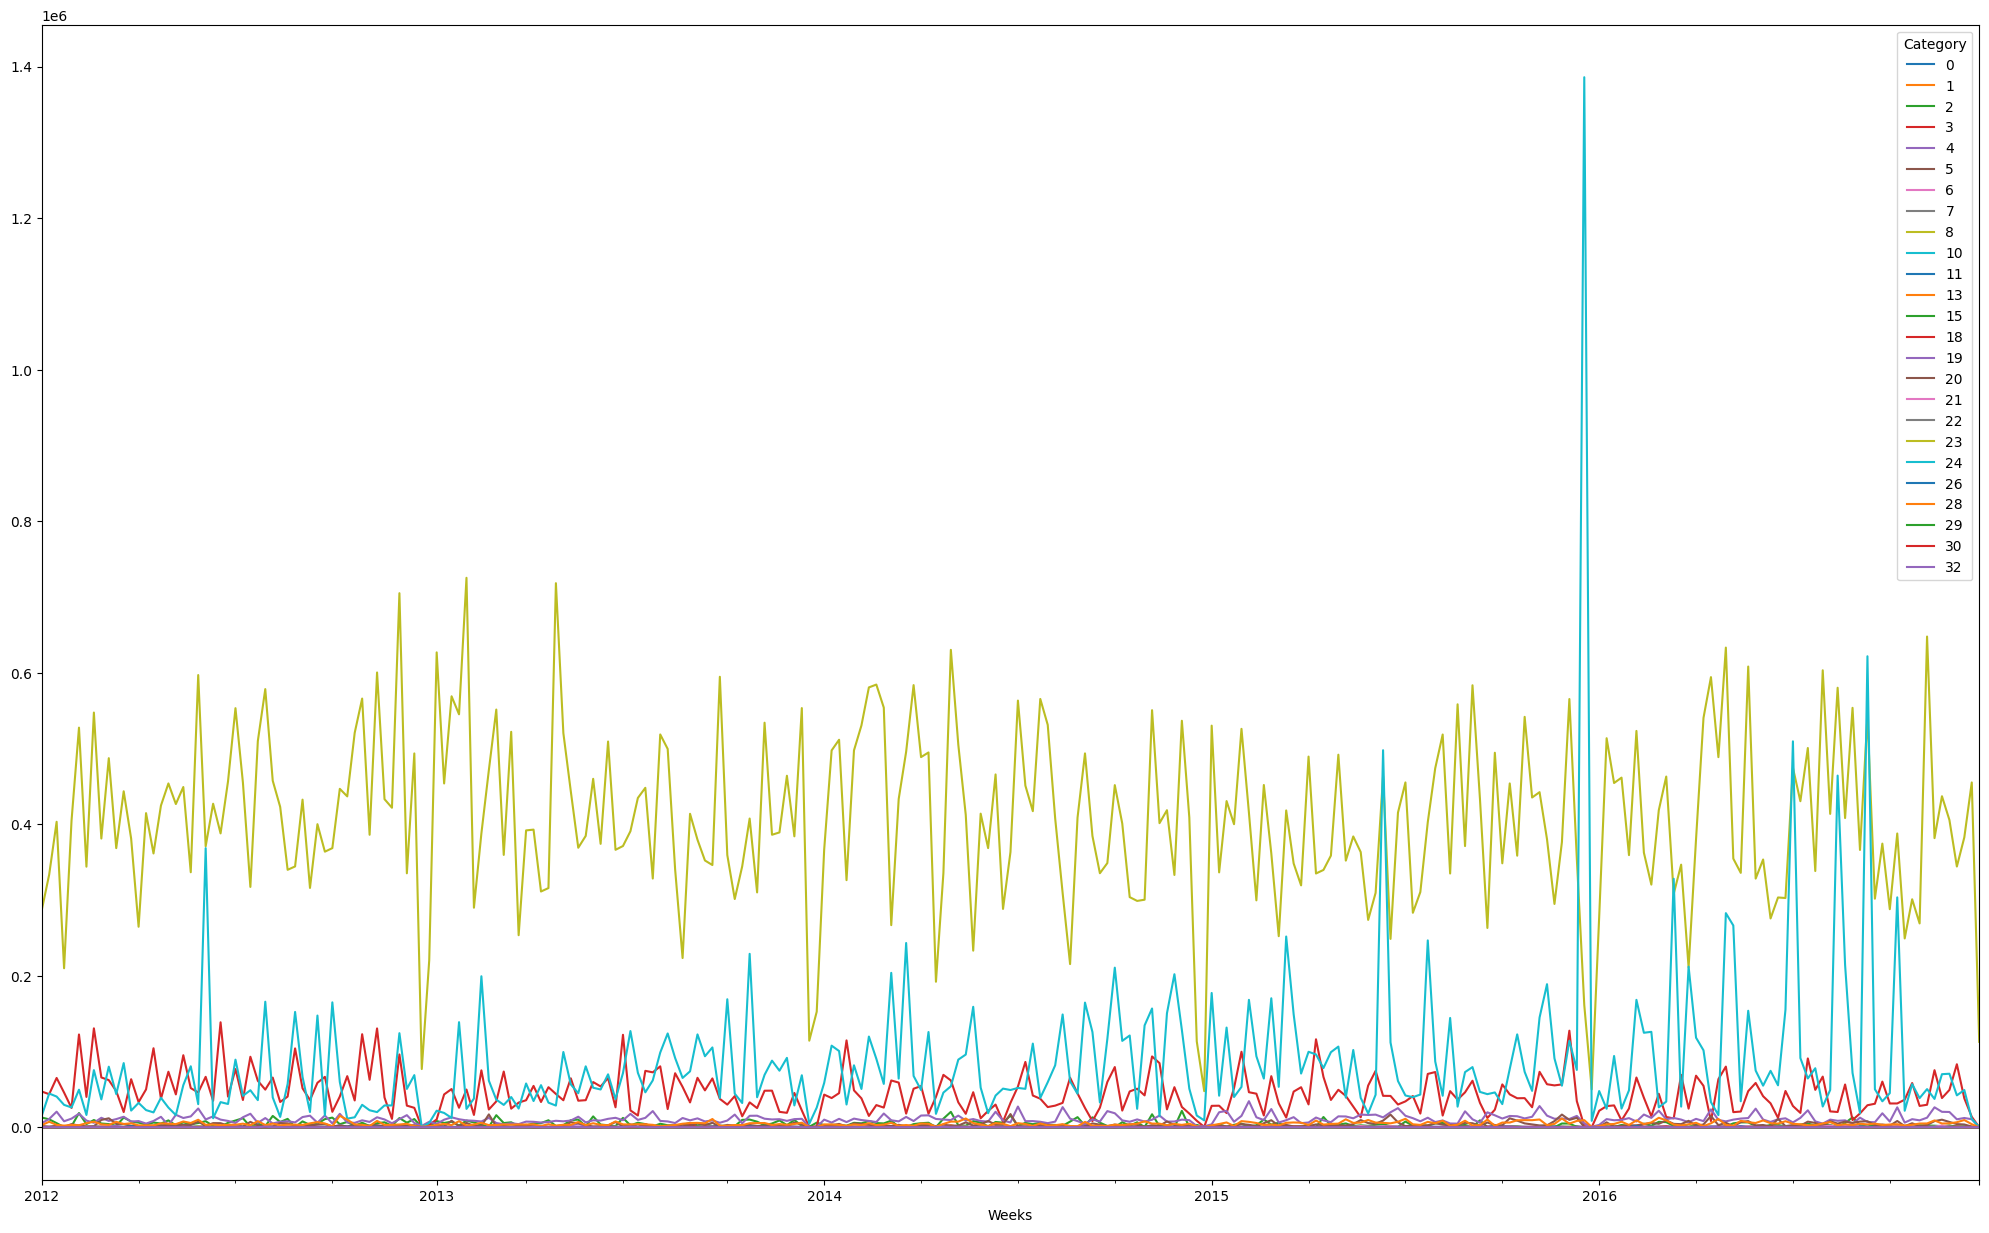

In [4]:
data_pivot = weekly.pivot(index='Weeks', columns='Category', values='Order_Demand').fillna(0)
data_pivot.plot(figsize=(25, 15))

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_pivot)

In [6]:
N = data_pivot.shape[1]
History = 4 # Weeks

In [29]:
def data():
    X = scaled_data
    inputs = []
    predictions = []
    for i in range(History, len(X)-History):
        x_input = X[i-History:i]
        z = X[i:i+History]
        inputs.append(x_input)
        predictions.append(z)
    return inputs, np.array(predictions)        
i,l = data()

In [31]:
i[0].shape

(4, 25)

In [43]:
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=4,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 3 files: 100%|████████████████████████| 3/3 [00:00<00:00, 13827.38it/s]


In [61]:
ts_id = 1
point_forecast, experimental_quantile_forecast = tfm.forecast(
    i[ts_id].T,
    freq=[0 for _ in range(len(i[ts_id].T))],
)

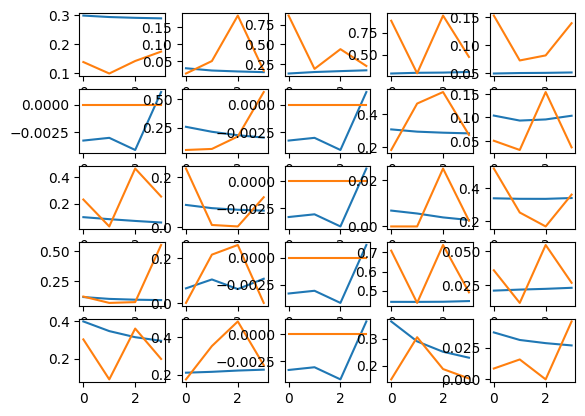

In [62]:
for seq in range(0, 25):
    plt.subplot(5, 5, seq + 1)
    plt.plot(point_forecast[seq, : ])
    plt.plot(l[ts_id,:,seq])